# Risk Factor Clinical Classifier

This classifier takes patient answers to the Lung Space clinical survey and predicts the chance of cancer.

## Import dataset and build dataframe

In [1095]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


# Breakdown of positive and negative sample size
print("positive: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 1].to_list()), " negative: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 0].to_list()))

# Features
features_demographic = ['age', 'weight', 'height', 'gender', 'educat', 'ethnic', 'race']
features_smoking = ["cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr"]
features_screening = ['num_screens']
features_follow_up_procedures = ["biop0","biop1","biop2","bioplc","invas0","invas1","invas2","invaslc","medcomp0","medcomp1","medcomp2","medcomplc","mra_stat0","mra_stat1","mra_stat2","no_proc_reas0","no_proc_reas1","no_proc_reas2","proc0","proc1","proc2"]
features_work_history = ["resasbe","resbaki","resbutc","reschem","resfarm","resfire","resflou","resfoun","reshard","respain","ressand","resweld","wrkasbe","wrkbaki","wrkbutc","wrkchem","wrkcoal","wrkcott","wrkfarm","wrkfire","wrkflou","wrkfoun","wrkhard","wrkpain","wrksand","wrkweld"]
features_disease_history = ["ageadas","ageasbe","agebron","agechas","agechro","agecopd","agediab","ageemph","agehear","agehype","agepneu","agestro","agetube","diagadas","diagasbe","diagbron","diagchas","diagchro","diagcopd","diagdiab","diagemph","diagfibr","diaghear","diaghype","diagpneu","diagsarc","diagsili","diagstro","diagtube"]
features_family_history = ["fambrother","famchild","famfather","fammother","famsister"]
features_alcohol = ["acrin_alc_curr","acrin_alc_ever","acrin_drink24hr","acrin_drinknum_curr","acrin_drinknum_form","acrin_drinkyrs_curr","acrin_drinkyrs_form","acrin_lastdrink","lss_alcohol_freq","lss_alcohol_num"]
output_column = ['lung_cancer']


positive:  2058  negative:  51394


/tmp/ipykernel_7835/3375708775.py:8: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


## Choose features to include

### Features: Demographics and Smoking

- Random forest (default): 99.8% accuracy
- K Nearest Neighbor: 94% accuracy
- Logistic Regression: 70% accuracy

In [1096]:
# dataset_columns = features_demographic + features_smoking + output_column


### Features: Demographics, Smoking, Work History, Family History, Alcohol

- Random forest (default): 99.9% accuracy
- K Nearest Neighbor (3 neighbors): 94%
- Logistic Regression: 64%

In [1097]:
dataset_columns = features_demographic + features_smoking + features_work_history + features_family_history + features_alcohol + output_column


### Features: Demographics, Work History, Family History, Alcohol

- Random forest (default): 98% accuracy
- KNN (3 neighbors): 93% accuracy
- Logistic Regression: 59% accuracy

In [1098]:
# dataset_columns = features_demographic + features_work_history + features_family_history + features_alcohol + output_column


## Remove null values and add weight/height field

In [1099]:
# Build dataframe
df = df[dataset_columns]
for i in dataset_columns[:]:
  if df[i].isna().sum() > 500:
    df = df.drop(i, axis=1)
    dataset_columns.remove(i)

# print(df.isnull().sum(axis = 0).sort_values(ascending=False).to_string())

df = df.dropna()

# df.insert(2, 'weight_div_height', df['weight'] / df['height'])

print(df)


       age  weight  height  gender  educat  ethnic  race  cigar  cigsmok  \
0       70   134.0    70.0       1       2       2     1    1.0        1   
1       66   175.0    68.0       1       3       2     1    0.0        1   
2       64   180.0    70.0       1       3       2     1    0.0        1   
3       60   205.0    70.0       1       5       2     1    0.0        0   
4       64   220.0    67.0       1       2       2     1    0.0        0   
...    ...     ...     ...     ...     ...     ...   ...    ...      ...   
53447   73   206.0    64.0       2       3       2     1    0.0        1   
53448   66   175.0    71.0       1       2       2     1    0.0        1   
53449   56   172.0    72.0       1       5       2     1    1.0        0   
53450   69   210.0    68.0       1       4       2     1    0.0        0   
53451   57   220.0    69.0       1       7       2     1    0.0        1   

       pipe  ...  wrkcott  wrkfarm  wrkfire  wrkflou  wrkfoun  wrkhard  \
0       1.0  

## Downsample the negative samples to balance the dataset

In [1100]:
# # Determines how many negative samples to include in the dataset
# # The frac value determines the percent of negative values that are excluded
# print(df)
# df = df.drop(df.query('lung_cancer == 0').sample(frac=.95).index)
# print(df)

# df = df[df[dataset_columns] >= 0]
# print("##############")
# print(df)

# print("!!!!!!!!!!!!!!!!!!!!!")

# for i in df.columns.to_list():
#   if df[i].isna().sum() > 500:
#     print(i)

# print("$$$$$$$$$$$$$")

# df = df.dropna()
# print(df)


## Duplicate the positive examples to balance the dataset

In [1101]:
# Duplicate the positive samples to balance the dataset

# df_positives = df[df['lung_cancer'] == 1]
# print(df_positives)
# print(len(df_positives['lung_cancer'].to_list()))

# while len(df[df['lung_cancer'] == 1]['lung_cancer'].to_list()) < len(df[df['lung_cancer'] == 0]['lung_cancer'].to_list()):
#   df = pd.concat([df, df_positives])

# print(df)
# print("positive: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 1].to_list()), " negative: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 0].to_list()))


## Define models

In [1102]:
from imblearn.over_sampling import RandomOverSampler


In [1103]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model names
names = [
    "Nearest Neighbors",
    "Linear SVM",
    # "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    # "Random Forest",
    # "Neural Net",
    # "AdaBoost",
    "Naive Bayes",
    "Logistic Regression"
    # "QDA",
]

# Models
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    # SVC(gamma=2, C=1, random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    # RandomForestClassifier(
    #     max_depth=5, n_estimators=10, max_features=1, random_state=42
    # ),
    # MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    # AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=0)
    # QuadraticDiscriminantAnalysis(),
]


## Build training and test sets

In [1104]:
# Use predict lung_cancer column
# X = df[['age', 'weight', 'height', "cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr","num_screens"]]
X = df[dataset_columns[:-1]]
y = df[['lung_cancer']]

# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)


## Balance the dataset to improve positive accuracy

### Oversample the imbalanced data with imbalance-learn library

In [1105]:
# ros = RandomOverSampler(random_state=0)
# X_train, y_train = ros.fit_resample(X_train, y_train)

# from imblearn.over_sampling import SMOTE, ADASYN
# # X_train, y_train = SMOTE().fit_resample(X_train, y_train)
# # X_train, y_train = ADASYN().fit_resample(X_train, y_train)


### Or oversample positive samples manually by duplicating them in the training set

In [1106]:
# X_train_positives = []
# X_test_positives = []
# y_train_positives = []
# y_test_positives = []

# train_temp = pd.concat([X_train, y_train['lung_cancer']], axis=1)
# test_temp = pd.concat([X_test, y_test['lung_cancer']], axis=1)

# df_train_positives = train_temp[train_temp['lung_cancer'] == 1]
# print(df_train_positives)
# print(len(df_train_positives['lung_cancer'].to_list()))

# while len(train_temp[train_temp['lung_cancer'] == 1]['lung_cancer'].to_list()) < len(train_temp[train_temp['lung_cancer'] == 0]['lung_cancer'].to_list()):
#   train_temp = pd.concat([train_temp, df_train_positives])

# print(train_temp)
# print("positive: ", len(train_temp['lung_cancer'].loc[train_temp['lung_cancer'] == 1].to_list()), " negative: ", len(train_temp['lung_cancer'].loc[train_temp['lung_cancer'] == 0].to_list()))

# ##########

# df_test_positives = test_temp[test_temp['lung_cancer'] == 1]
# print(df_test_positives)
# print(len(df_test_positives['lung_cancer'].to_list()))

# while len(test_temp[test_temp['lung_cancer'] == 1]['lung_cancer'].to_list()) < len(test_temp[test_temp['lung_cancer'] == 0]['lung_cancer'].to_list()):
#   test_temp = pd.concat([test_temp, df_test_positives])

# print(test_temp)
# print("positive: ", len(test_temp['lung_cancer'].loc[test_temp['lung_cancer'] == 1].to_list()), " negative: ", len(test_temp['lung_cancer'].loc[test_temp['lung_cancer'] == 0].to_list()))


# y_train = pd.DataFrame({'lung_cancer': train_temp['lung_cancer']})

# print("TRAIN TEMP")
# print(train_temp)
# train_temp = train_temp.drop('lung_cancer', axis=1)
# X_train = train_temp

# y_test = pd.DataFrame({'lung_cancer': test_temp['lung_cancer']})

# test_temp = test_temp.drop('lung_cancer', axis=1)
# X_test = test_temp


In [1107]:
print(y_train)
print(y_test)

print("positive training sample: ", len(list(filter(lambda x: x == 1.0, y_train['lung_cancer'].to_list()))))
print("negative training sample: ", len(list(filter(lambda x: x == 0.0, y_train['lung_cancer'].to_list()))))
print("positive training sample: ", len(list(filter(lambda x: x == 1.0, y_test['lung_cancer'].to_list()))))
print("negative training sample: ", len(list(filter(lambda x: x == 0.0, y_test['lung_cancer'].to_list()))))


       lung_cancer
14844            0
564              0
18862            0
26075            0
37952            0
...            ...
11593            0
45785            0
39134            0
885              0
16216            0

[31375 rows x 1 columns]
       lung_cancer
49592            0
41771            0
35917            0
15057            0
11201            0
...            ...
2620             0
3695             0
16138            0
21811            1
18824            0

[20917 rows x 1 columns]
positive training sample:  1168
negative training sample:  30207
positive training sample:  835
negative training sample:  20082


## Test models and plot confusion matrices

The goal is to minimize the number of false negative predictions.

In [1108]:
# for name, clf in zip(names, classifiers):
#   clf = make_pipeline(StandardScaler(), clf)
#   clf.fit(normalize(X_train), y_train)
#   y_pred = clf.predict(normalize(X_test))

#   score = accuracy_score(y_test, y_pred)
#   conf_matrix = confusion_matrix(y_test, y_pred)
#   disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
#   disp.plot()
#   print("Model: ", name, " score: ", score)



# for name, m in zip(names, classifiers):
#   # clf = m = SVC(kernel="linear", C=0.025, random_state=42, probability=True)
#   clf = make_pipeline(StandardScaler(), m)
#   clf.fit(normalize(X_train), y_train)
#   y_pred = clf.predict(normalize(X_test))
#   # y_pred_prob = clf.predict_proba(X_test)

#   print(name)
#   # print(y_pred_prob)

#   score = accuracy_score(y_test, y_pred)
#   conf_matrix = confusion_matrix(y_test, y_pred)
#   print(conf_matrix)
#   print(f"Accuracy on positive samples: {conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])}")
#   print(f"Accuracy on negative samples: {conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])}")
#   disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
#   disp.plot()
#   print("Model: ", name, " score: ", score)


## Get confidence of each prediction with `predict_proba()`

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[0.68753726 0.31246274]
 [0.4699898  0.5300102 ]
 [0.44082773 0.55917227]
 ...
 [0.73117009 0.26882991]
 [0.20648803 0.79351197]
 [0.47480675 0.52519325]]
[[ 7130 12952]
 [  128   707]]
Accuracy on positive samples: 0.8467065868263473
Accuracy on negative samples: 0.35504431829499056
Model:  Logistic Regression  score:  0.37467131997896447


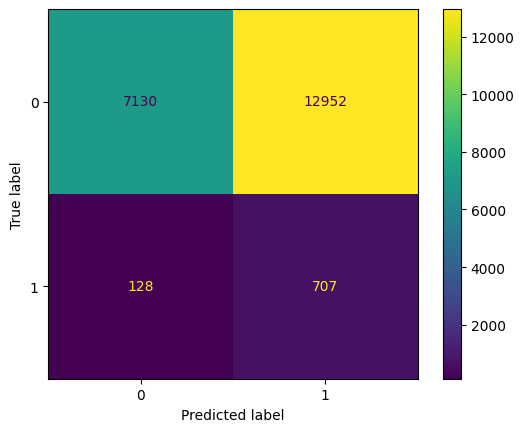

In [1109]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

# # X_train, y_train = SMOTE().fit_resample(X_train, y_train)
# # X_train, y_train = ADASYN().fit_resample(X_train, y_train)
m = LogisticRegression(random_state=0)
clf = make_pipeline(
    # RandomUnderSampler(random_state=0),
    # RandomOverSampler(random_state=0),
    # ClusterCentroids(random_state=0), # good
    # NearMiss(version=1),
    SMOTE(), # good
    # ADASYN(),
    m
)

# clf = m = SVC(kernel="linear", C=0.025, random_state=42, probability=True)
# clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(normalize(X_test))

print(y_pred_prob)

# skew results
for i in range(len(y_pred)):
  if y_pred[i] == 0 and y_pred_prob[i][0] <= 0.62:
    y_pred[i] = 1

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print(f"Accuracy on positive samples: {conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])}")
print(f"Accuracy on negative samples: {conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "Logistic Regression", " score: ", score)


## Rank features used 

In [1110]:
# Create lists of feature names and coefficients
column_labels = X_train.columns.tolist()
coef = m.coef_.squeeze().tolist()

# Zip together
labels_coef = list(zip(column_labels, coef))
# Order by most significant features (positive or negative)
feature_ranks = sorted(labels_coef, key=lambda x: abs(x[1]), reverse=True)

print(feature_ranks)


[('pkyr', 10.722806366531161), ('smokeyr', 10.654958757065588), ('smokeday', -8.708865584170281), ('weight', 7.7625831653103505), ('smokeage', 3.0973958694610215), ('age', 3.05755339674893), ('gender', -3.021714076086089), ('race', -2.935098462221484), ('ethnic', 2.9133778383364164), ('height', -1.156915223532337), ('cigsmok', 0.9752979583366691), ('smokework', 0.9373816450776489), ('smokelive', -0.8868359382213625), ('wrkchem', 0.7488955380469722), ('wrkflou', 0.4929205439605467), ('wrkweld', 0.46521553511525104), ('wrkfire', 0.45678446976943365), ('wrkfarm', 0.45390005597656086), ('educat', 0.44888830775860444), ('wrkfoun', 0.4357522512955507), ('pipe', 0.42109203044465565), ('cigar', -0.3010412776781395), ('wrkbutc', -0.17980712357552178), ('wrkpain', 0.1610558563675861), ('wrkbaki', -0.14152580131428585), ('wrksand', 0.1130431517095637), ('wrkasbe', 0.10441314387854062), ('wrkhard', -0.08861299099495618), ('wrkcoal', 0.045312643819883196), ('wrkcott', 0.010092943423134056)]


## Compare compare the probabilities of false positives and false negatives to true positives and true negatives

In [1111]:
true_negative_probs = []
false_negative_probs = []
true_positive_probs = []
false_positive_probs = []

y_pred_list = y_pred.tolist()
y_pred_prob_list = y_pred_prob.tolist()
y_test_list = y_test['lung_cancer'].tolist()

for i in range(len(y_test)):
  # true negative
  if y_pred_list[i] == 0 and y_test_list[i] == 0:
    true_negative_probs.append(y_pred_prob_list[i][0])
  # false negative
  elif y_pred_list[i] == 0 and y_test_list[i] == 1:
    false_negative_probs.append(y_pred_prob_list[i][0])
  # true positive
  elif y_pred_list[i] == 1 and y_test_list[i] == 1:
    true_positive_probs.append(y_pred_prob_list[i][1])
  # false positive
  else:
    false_positive_probs.append(y_pred_prob_list[i][1])


## Plot the confidence intervals that led to the different predictions. 

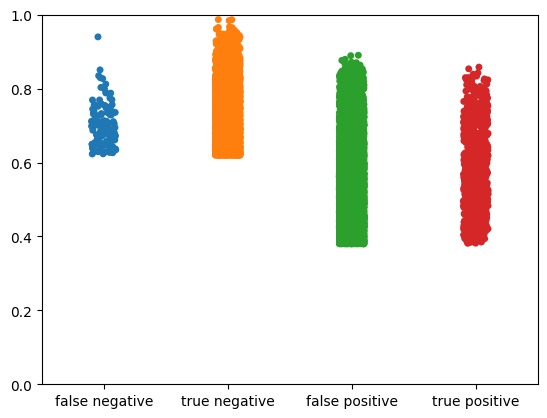

In [1112]:
data = {'false negative': false_negative_probs,
               'true negative': true_negative_probs,
               'false positive': false_positive_probs,
               'true positive': true_positive_probs,
              }
cols = ['false negative', 'true negative', 'false positive', 'true positive']

df = pd.DataFrame.from_dict(
    data=dict(data),
    orient='index',
).T

fig, ax = plt.subplots()

ax = sns.stripplot(data=df)
ax.set_ylim(0, 1)

plt.show()


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model:  KNN  score:  0.5675288043218435


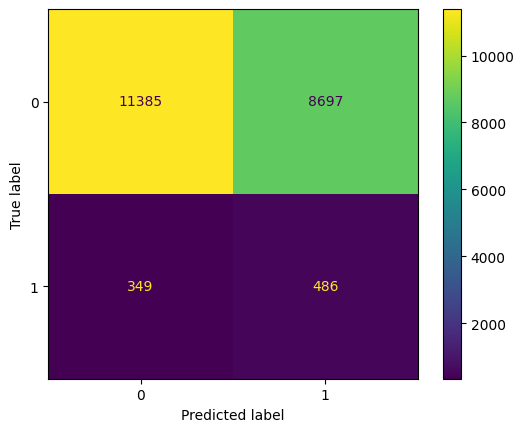

In [1113]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

m = KNeighborsClassifier(3)
clf = make_pipeline(
    RandomUnderSampler(random_state=0),
    # ClusterCentroids(random_state=0), # good
    # NearMiss(version=1),
    # SMOTE(), # good
    # ADASYN(),
    m
)
# clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(normalize(X_test))

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "KNN", " score: ", score)

# # Fit logistic regression model
# model2 = KNeighborsClassifier(3)
# model2.fit(X_train, y_train)

# # Get confidence intervals for each prediction
# y_pred_prob = model2.predict_proba(X_test)
# # Get predicted values
# y_pred = model2.predict(normalize(X_test))

# # Get prediction accuracy
# score = accuracy_score(y_test, y_pred)
# # Get breakdown of false/true positives and false/true negatives
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display results
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
# disp.plot()
# print("Model: ", "KNN", " score: ", score)


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model:  Random Forest  score:  0.6151455753693168


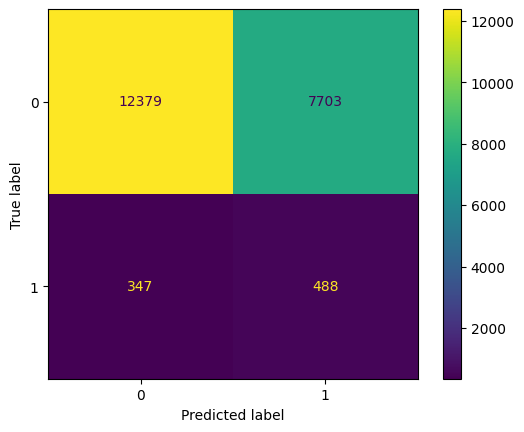

In [1114]:
m = RandomForestClassifier()
clf = make_pipeline(
    RandomUnderSampler(random_state=0),
    # ClusterCentroids(random_state=0), # good
    # NearMiss(version=1),
    # SMOTE(), # good
    # ADASYN(),
    m
)
# clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(normalize(X_test))

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "Random Forest", " score: ", score)


In [1115]:
# Create lists of feature names and coefficients
column_labels = X_train.columns.tolist()
coef = m.feature_importances_

# Zip together
labels_coef = list(zip(column_labels, coef))
# Order by most significant features (positive or negative)
feature_ranks = sorted(labels_coef, key=lambda x: abs(x[1]), reverse=True)

print(feature_ranks)


[('smokeyr', 0.10083191668679027), ('pkyr', 0.08323868517569455), ('weight', 0.07876945798253945), ('educat', 0.06912541744492737), ('age', 0.06900926605674676), ('smokeage', 0.06823773359231028), ('smokeday', 0.06416241388639317), ('height', 0.05969494001588284), ('race', 0.056672247501494924), ('ethnic', 0.0564367164159113), ('gender', 0.05500213007019787), ('smokelive', 0.05104865402265559), ('smokework', 0.04856159131674845), ('cigsmok', 0.03927260698938432), ('pipe', 0.020408685758947557), ('cigar', 0.01763328190727488), ('wrkfarm', 0.011221743519206007), ('wrkchem', 0.008834989756647553), ('wrkpain', 0.007904857613027685), ('wrkweld', 0.005950852847132775), ('wrkasbe', 0.005818919919012558), ('wrkfoun', 0.004519397472528895), ('wrkbutc', 0.0044590201657580455), ('wrkbaki', 0.004237518988515114), ('wrkfire', 0.0030777987172130763), ('wrkflou', 0.002055058754910822), ('wrksand', 0.0017928360595488922), ('wrkcott', 0.0008384074661047392), ('wrkcoal', 0.0007428863191498167), ('wrkhar

In [1116]:
true_negative_probs = []
false_negative_probs = []
true_positive_probs = []
false_positive_probs = []

y_pred_list = y_pred.tolist()
y_pred_prob_list = y_pred_prob.tolist()
y_test_list = y_test['lung_cancer'].tolist()

for i in range(len(y_test)):
  # true negative
  if y_pred_list[i] == 0 and y_test_list[i] == 0:
    true_negative_probs.append(y_pred_prob_list[i][0])
  # false negative
  elif y_pred_list[i] == 0 and y_test_list[i] == 1:
    false_negative_probs.append(y_pred_prob_list[i][0])
  # true positive
  elif y_pred_list[i] == 1 and y_test_list[i] == 1:
    true_positive_probs.append(y_pred_prob_list[i][1])
  # false positive
  else:
    false_positive_probs.append(y_pred_prob_list[i][1])


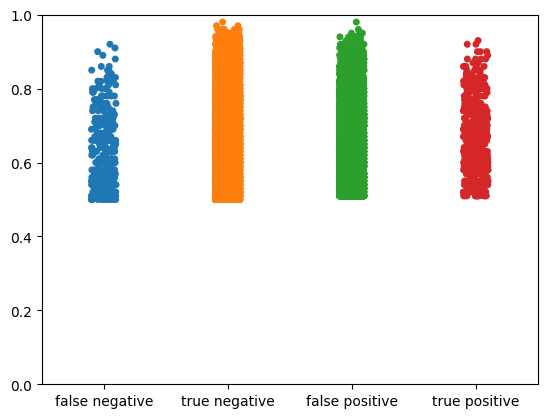

In [1117]:
data = {'false negative': false_negative_probs,
               'true negative': true_negative_probs,
               'false positive': false_positive_probs,
               'true positive': true_positive_probs,
              }
cols = ['false negative', 'true negative', 'false positive', 'true positive']

df = pd.DataFrame.from_dict(
    data=dict(data),
    orient='index',
).T

fig, ax = plt.subplots()

ax = sns.stripplot(data=df)
ax.set_ylim(0, 1)

plt.show()


In [1118]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(clf, X, y, cv=10)
# print(scores)


In [1119]:
# from sklearn.svm import OneClassSVM

# clf = OneClassSVM(gamma='auto').fit(X_train)

# output = clf.predict(X_train)

# print()


In [1120]:
# print(output)

# print(len(output))
# print(len(y_train))

# print(y_train)

# false_pos = 0
# false_neg = 0
# true_pos = 0
# true_neg = 0

# for i in range(len(output)):
#   if output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 0:
#     true_neg += 1
#   elif output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 1:
#     false_neg += 1
#   elif output[i] == -1 and y_train.iloc[i]['lung_cancer'] == 0:
#     false_pos += 1
#   else:
#     true_pos += 1

# print("false_pos: ", false_pos, " true_pos ", true_pos, " false_neg ", false_neg, " true_neg ", true_neg)


In [1121]:
# scores = clf.score_samples(X_train)


In [1122]:
# print(sorted(scores, reverse=True))

# new_output = output[:]

# for i in range(len(new_output)):
#   if scores[i] < 2 and new_output[i] == -1:
#     new_output[i] = 1
#   elif scores[i] >= 2 and new_output[i] == 1:
#     new_output[i] = -1

# false_pos = 0
# false_neg = 0
# true_pos = 0
# true_neg = 0

# for i in range(len(output)):
#   if new_output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 0:
#     true_neg += 1
#   elif new_output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 1:
#     false_neg += 1
#   elif new_output[i] == -1 and y_train.iloc[i]['lung_cancer'] == 0:
#     false_pos += 1
#   else:
#     true_pos += 1

# print("false_pos: ", false_pos, " true_pos ", true_pos, " false_neg ", false_neg, " true_neg ", true_neg)
